In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import sys
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(proj_dir,'data','analysis','interim')
src_dir = os.path.join(proj_dir,'src')
fig_dir = os.path.join(proj_dir,'reports','shallow_melting','figures')

sys.path.append(src_dir)
%load_ext autoreload
%autoreload 1

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

from log_progress import log_progress
from calc_z import calc_z

In [4]:
#grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
#grd = xr.open_dataset(grd_path)

#avg_path = os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc')
#avg = xr.open_dataset(avg_path)

grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_ymonmean.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_ymonmean.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_ymonmean.nc')
temp = xr.open_dataset(temp_path).temp
salt = xr.open_dataset(salt_path).salt
zeta = xr.open_dataset(zeta_path).zeta

avg = xr.Dataset({'salt':salt,'temp':temp,'zeta':zeta})

#ii = (zeta['ocean_time.month']==11) | (zeta['ocean_time.month']==1) | (zeta['ocean_time.month']==3) | (zeta['ocean_time.month']==5)

In [73]:
import string

def assign_depth(ds,zeta):
    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    zeta = zeta.values
    Vstretching = 4

    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)

    return ds.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

def plot_inset(ax,ylim,xlim):

    ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
    (grd.h+grd.zice).where(grd.mask_rho).plot(cmap=ocm.deep,add_colorbar=False)
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'))
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black')) 
    ax.set_aspect('equal')
    ax.axis('off')
    ax.plot([300*5, 300*5], [120*5, 160*5], color='k', linestyle='-', linewidth=2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

def make_axes(axes,month,eta,xi):
    avg_F = assign_depth(avg[['temp','salt']].isel(ocean_time=month),avg.zeta.isel(ocean_time=month))
    imgt = avg_F.temp[:,eta,xi].plot(ax=axes[0],x='eta_rho',y='depth',vmin=-2,vmax=-1.6,cmap=ocm.thermal,add_colorbar=False)
    imgs = avg_F.salt[:,eta,xi].plot(ax=axes[1],x='eta_rho',y='depth',vmin=34.2,vmax=34.5,cmap=ocm.haline,add_colorbar=False)
    axes[0].text(0.5, 0.9, f'Month of year: {month+1}', transform=axes[0].transAxes)
    return axes,imgt,imgs

def plot_section(eta,xi):
        
    fig,axes = plt.subplots(ncols=2,nrows=4,figsize=(8.27,10))
    for axp,month in log_progress(zip(axes,[10,0,2,4]),every=1):
        axp,imgt,imgs = make_axes(axp,month,eta,xi)    
   
    n=0
    for ax in axes.flatten():
        ax.set_ylim((-400,0))
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
        n+=1
        
    for ax in axes[:-1,:].flatten():
        ax.set_xticklabels('')
    for ax in axes[:,1].flatten():
        ax.set_yticklabels('')
    for ax in axes[:,0].flatten():
        ax.set_ylabel('Depth in m')
    for ax in axes[-1,:].flatten():
        ax.set_xlabel('Distance in km')
        ax.set_xticklabels([0,100,200,300,400])
        
    fig.subplots_adjust(bottom=0.165)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.3, 0.01])
    cbar = plt.colorbar(imgt, cax=cbar_ax, orientation="horizontal", pad=0.01)
    cbar.set_label(label='Potential Temperature [degC]')
    
    cbar_ax = fig.add_axes([0.55, 0.1, 0.3, 0.01])
    cbar = plt.colorbar(imgs, cax=cbar_ax, orientation="horizontal", pad=0.01)
    cbar.set_label(label='Salinity')
    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    axi = inset_axes(axes[0,1],height="40%",width="30%", loc=1)
    axi = plot_inset(axi,(110*5,210*5),(240*5,340*5))

    plt.subplots_adjust(wspace=0.05,hspace=0.07)
     
    out_path = os.path.join(fig_dir,'ASSW_advect_Ross.png')
    fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
    
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


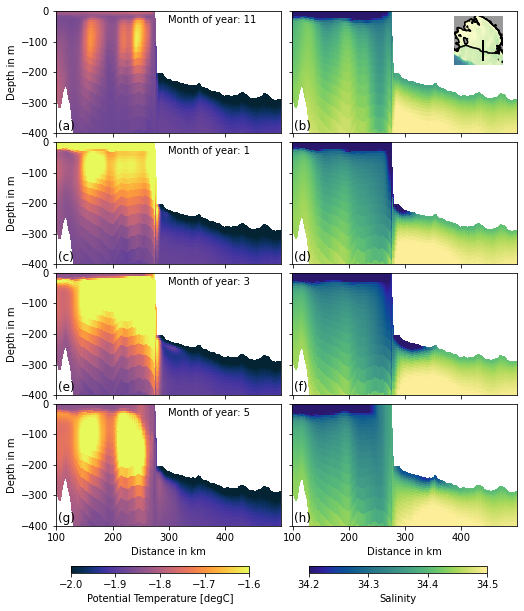

In [74]:
plot_section(slice(120*5,160*5),300*5)

In [31]:
grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
grd10 = xr.open_dataset(grd_path)

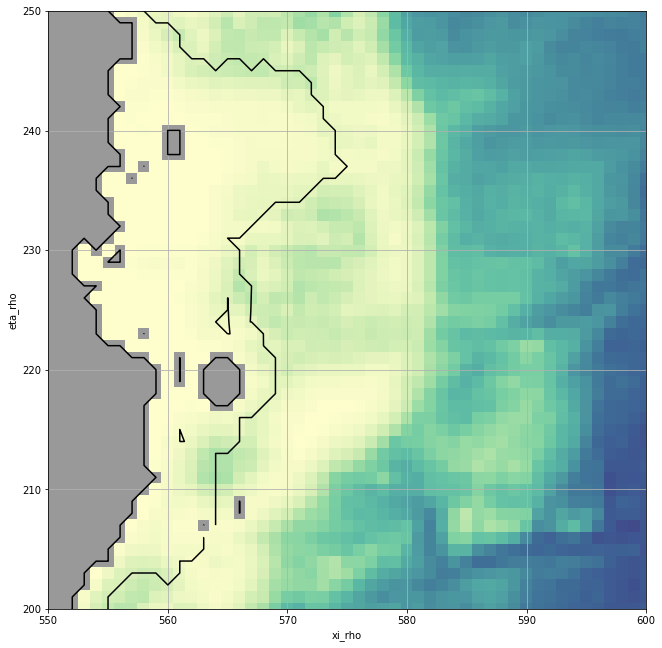

In [86]:
eta = [262, 262]
xi = [105, 115]

xlim = (550,600)
ylim = (200,250)

fig,ax = plt.subplots(figsize=(12,11))
ax.contourf(grd10.mask_rho.values,colors=(('0.6','0.6','0.6')))
(grd10.h+grd10.zice).where(grd10.mask_rho).plot(cmap=ocm.deep,add_colorbar=False)
ax.contour(-grd10.zice.where(grd10.mask_rho).values, levels=['0.01'], colors=('black'))
ax.contour(grd10.mask_rho.values, levels=['0.01'], colors=('black')) 
ax.set_aspect('equal')
#ax.axis('off')
ax.grid()
ax.plot(xi, eta, color='k', linestyle='-', linewidth=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [39]:
grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
grd10 = xr.open_dataset(grd_path)

avg_path = os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc')
avg10 = xr.open_dataset(avg_path)

In [67]:
import string

def assign_depth(ds,zeta):
    h = grd10.h.values
    zice = grd10.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    zeta = zeta.values
    Vstretching = 4

    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)

    return ds.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

def make_month(da,month,eta,xi):
    ii = da['ocean_time.month']==month
    return da[ii].isel({'eta_rho':eta,'xi_rho':xi}).groupby('ocean_time.month').mean('ocean_time')

def plot_inset(ax,ylim,xlim):

    ax.contourf(grd10.mask_rho.values,colors=(('0.6','0.6','0.6')))
    (grd10.h+grd10.zice).where(grd10.mask_rho).plot(cmap=ocm.deep,add_colorbar=False)
    ax.contour(-grd10.zice.where(grd10.mask_rho).values, levels=['0.01'], colors=('black'))
    ax.contour(grd10.mask_rho.values, levels=['0.01'], colors=('black')) 
    ax.set_aspect('equal')
    ax.axis('off')
    ax.plot([300, 300], [120, 160], color='k', linestyle='-', linewidth=2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

def make_axes(axes,month,eta,xi):
    avg10_F = assign_depth(avg10[['temp','salt']].isel(ocean_time=month),avg10.zeta.isel(ocean_time=month))
    imgt = avg10_F.temp[:,eta,xi].plot(ax=axes[0],x='xi_rho',y='depth',vmin=-2,vmax=-0.0,cmap=ocm.thermal,add_colorbar=False)
    imgs = avg10_F.salt[:,eta,xi].plot(ax=axes[1],x='xi_rho',y='depth',vmin=33.8,vmax=34.3,cmap=ocm.haline,add_colorbar=False)
    axes[0].text(0.5, 0.9, f'Month of year: {month+1}', transform=axes[0].transAxes)
    return axes,imgt,imgs

def plot_section(eta,xi):
        
    fig,axes = plt.subplots(ncols=2,nrows=4,figsize=(8.27,10))
    for axp,month in zip(axes,[10,0,2,4]):
        axp,imgt,imgs = make_axes(axp,month,eta,xi)    
   
    n=0
    for ax in axes.flatten():
        ax.set_ylim((-400,0))
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
        n+=1
        
    for ax in axes[:-1,:].flatten():
        ax.set_xticklabels('')
    for ax in axes[:,1].flatten():
        ax.set_yticklabels('')
    for ax in axes[:,0].flatten():
        ax.set_ylabel('Depth in m')
    for ax in axes[-1,:].flatten():
        ax.set_xlabel('Distance in km')
        ax.set_xticklabels([0,100,200,300,400])
        
    fig.subplots_adjust(bottom=0.165)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.3, 0.01])
    cbar = plt.colorbar(imgt, cax=cbar_ax, orientation="horizontal", pad=0.01)
    cbar.set_label(label='Potential Temperature [degC]')
    
    cbar_ax = fig.add_axes([0.55, 0.1, 0.3, 0.01])
    cbar = plt.colorbar(imgs, cax=cbar_ax, orientation="horizontal", pad=0.01)
    cbar.set_label(label='Salinity')
    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    axi = inset_axes(axes[0,1],height="40%",width="30%", loc=1)
    axi = plot_inset(axi,(110,210),(240,340))

    plt.subplots_adjust(wspace=0.05,hspace=0.07)
     
    #out_path = os.path.join(fig_dir,'ASSW_advect_Ross.png')
    #fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
    
    plt.show()

ValueError: x must be one of None, 'depth', 'eta_rho', 'ocean_time', 's_rho', 'x_rho', 'y_rho'

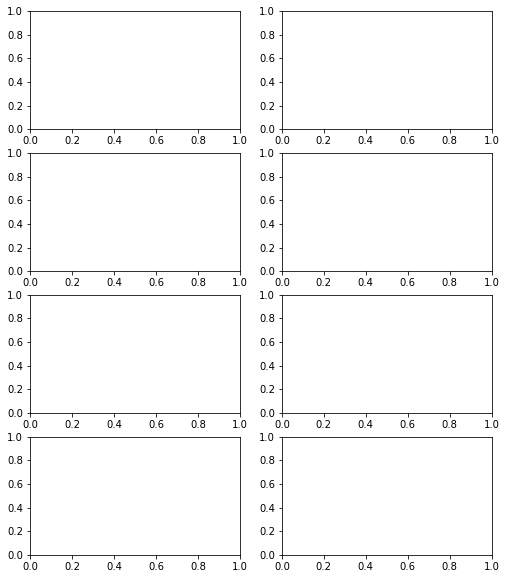

In [68]:
plot_section(slice(120,160),300)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator


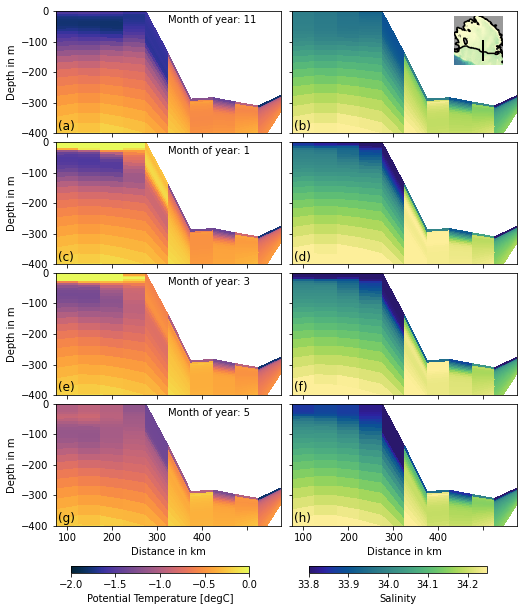

In [69]:
eta = [260, 260]
xi = [100, 115]
plot_section(262,slice(105,115))